# Functional Connectivity Analysis with Nilearn - Rest

This script closely follows [this example](https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html) provided through the Nilearn tutorials site.

In [1]:
from scipy import corrcoef
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn import cluster, metrics
import numpy as np
import pandas as pd
import os

### The Schaefer Local-Global Parcellation

The Schaefer 2018 parcellation is available from the [CBIG GitHub Repo](https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal).

In [2]:
from nilearn import datasets
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=2, data_dir='/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer')
atlas_filename = dataset.maps
labels = dataset.labels

print('Atlas ROIs are located in nifti image (4D) at: %s' % atlas_filename)  # 4D data
from nilearn import plotting
plotting.plot_roi(atlas_filename)

Atlas ROIs are located in nifti image (4D) at: /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


In [3]:
schaefer_coords = np.loadtxt('data/schaefer400/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv', delimiter = ',', skiprows=2, usecols=(2,3,4))
schaefer_coords = tuple(map(tuple, schaefer_coords))
schaefer_coords[:5]

((-36.0, -62.0, -16.0),
 (-24.0, -72.0, -10.0),
 (-36.0, -82.0, -16.0),
 (-16.0, -86.0, -16.0),
 (-24.0, -96.0, -12.0))

### Load task data  
Comparing task to rest.

Right now, I'm only using the second run of MemMatch for testing and because I'm hoping the second run is less sensitive to warm-up effects and memory deterioration from elapsed time.

In [4]:
task = 'REST'

In [5]:
from nipype.interfaces.io import DataFinder

data_dir = '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep'
os.path.isdir(data_dir)

df = DataFinder()
df.inputs.root_paths = data_dir
df.inputs.match_regex = ('%s.+preproc_bold.nii.gz' % task)
df_result = df.run()
fmri_filenames = df_result.outputs.out_paths

conf = DataFinder()
conf.inputs.root_paths = data_dir
conf.inputs.match_regex = ('%s.+regressors.tsv' % task)
conf_result = conf.run()
conf_filenames = conf_result.outputs.out_paths

In [6]:
print(fmri_filenames[:5])

['/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30004/func/sub-30004_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30008/func/sub-30008_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30009/func/sub-30009_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30012/func/sub-30012_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30015/func/sub-30015_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']


In [7]:
conf_cols = ['csf', 'white_matter', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement']

For some reason, subject 30274 had an older version of fmriprep so the confounds file wasn't able to be read. This just checks that that subject is no longer in the line up for the time being.
Problems with: 40608, 40658

### Extract timeseries
I'm detrending the data and applying a bandpass filter from 0.08 to 0.1 Hz. Timeseries are organized into an array with all subjects (pooled_subjects), as well as by age group (oa_ts, ya_ts).

Running this for the whole dataset will take some time, so take a coffee break :)

### Exclusion criteria

Excluding participants with mean framewise displacement > 0.25 mm AND participants who have more than 15% of TRs with framewise displacement over 0.25 mm

In [31]:
fd_thresh = 0.25

In [13]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, detrend=True, verbose=5, low_pass=0.1, high_pass=0.08, t_r=1.5)
fmri_file = fmri_filenames[52]
confound_file = conf_filenames[52]
print(fmri_file)
confounds = pd.read_csv(confound_file, sep = '\t', usecols = conf_cols)
confounds['fd_scrub'] = np.where(confounds['framewise_displacement'] > 0.20, 0, 1)

/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40170/func/sub-40170_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


In [32]:
if ((confounds['framewise_displacement'] > fd_thresh).sum() & (confounds['framewise_displacement'] > fd_thresh).sum() < 0.15*(len(confounds['framewise_displacement']))):
    print('good to go')
else:
    print('exclude')

good to go


In [33]:
(confounds['framewise_displacement'] > fd_thresh).sum() & (confounds['framewise_displacement'] > fd_thresh).sum() < 0.15*(len(confounds['framewise_displacement']))

True

In [34]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, detrend=True, verbose=5, low_pass=0.1, high_pass=0.08, t_r=1.5)

oa_ts = []
ya_ts = []
# all_ts = []
# all_list = []
oa_list = []
ya_list = []
for fmri_file, confound_file in zip(fmri_filenames, conf_filenames):
    
    confounds = pd.read_csv(confound_file, sep = '\t', usecols = conf_cols)
    confounds['fd_scrub'] = np.where(confounds['framewise_displacement'] > fd_thresh, 0, 1)
    if ((confounds['framewise_displacement'] > fd_thresh).sum() & (confounds['framewise_displacement'] > fd_thresh).sum() < 0.15*(len(confounds['framewise_displacement']))):
        confounds = confounds.drop(columns = 'framewise_displacement')
        confounds = confounds.values

        time_series = masker.fit_transform(fmri_file, confounds=confounds)
#         all_ts.append(time_series)
#         all_list.append(partic)
        partic = fmri_file.split('sub-',1)[1]
        partic = partic[0:5]
        if int(partic) >= 40000:
            oa_ts.append(time_series)
            oa_list.append(partic)
        else:
            ya_ts.append(time_series)
            ya_list.append(partic)
        print('Data has {0} OA subjects.'.format(len(oa_ts)))
        print('Data has {0} YA subjects.'.format(len(ya_ts)))
    else:
        print('Excluded participant %s - framewise displacement' % partic)

np.save('data/%s_oa_ts' % task, oa_ts)
np.save('data/%s_ya_ts' % task, ya_ts)

np.save('data/%s_oa_list' % task, oa_list)
np.save('data/%s_ya_list' % task, ya_list)


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30004/func/sub-30004_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 1 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30008/func/sub-30008_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 2 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30009/func/sub-30009_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 3 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30012/func/sub-30012_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 4 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30015/func/sub-30015_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 5 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30019/func/sub-30019_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 6 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30020/func/sub-30020_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 7 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30023/func/sub-30023_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 8 YA subjects.
Excluded participant 30023 - framewise displacement


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30057/func/sub-30057_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 9 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30064/func/sub-30064_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 10 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30066/func/sub-30066_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 11 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30069/func/sub-30069_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 12 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30074/func/sub-30074_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 13 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30085/func/sub-30085_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 14 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30088/func/sub-30088_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 15 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30090/func/sub-30090_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 16 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30091/func/sub-30091_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 17 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30095/func/sub-30095_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 18 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30096/func/sub-30096_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 19 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30105/func/sub-30105_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 20 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30116/func/sub-30116_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 21 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30118/func/sub-30118_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 22 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30119/func/sub-30119_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 23 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30128/func/sub-30128_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 24 YA subjects.
Excluded participant 30128 - framewise displacement


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30217/func/sub-30217_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 25 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30227/func/sub-30227_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 26 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30236/func/sub-30236_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 27 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30242/func/sub-30242_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 28 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30255/func/sub-30255_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 29 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30283/func/sub-30283_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 30 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30295/func/sub-30295_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 31 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30330/func/sub-30330_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 32 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30346/func/sub-30346_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 33 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30376/func/sub-30376_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 34 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30395/func/sub-30395_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 35 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30400/func/sub-30400_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 36 YA subjects.
Excluded participant 30400 - framewise displacement


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30412/func/sub-30412_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 37 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30426/func/sub-30426_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 38 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30432/func/sub-30432_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 39 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30466/func/sub-30466_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 40 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30469/func/sub-30469_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 41 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30476/func/sub-30476_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 42 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30478/func/sub-30478_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 43 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30568/func/sub-30568_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 44 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30570/func/sub-30570_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30581/func/sub-30581_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 46 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30584/func/sub-30584_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 47 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30588/func/sub-30588_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40160/func/sub-40160_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 1 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40170/func/sub-40170_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 2 OA subjects.
Data has 48 YA subjects.
Excluded participant 40170 - framewise displacement


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40288/func/sub-40288_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 3 OA subjects.
Data has 48 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40351/func/sub-40351_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 4 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Excluded participant 40351 - framewise displacement
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40496/func/sub-40496_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 5 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Excluded participant 40496 - framewise displacement
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40512/func/sub-40512_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 6 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40515/func/sub-40515_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 7 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Excluded participant 40515 - framewise displacement
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40519/func/sub-40519_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 8 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40520/func/sub-40520_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 9 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40522/func/sub-40522_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 10 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40524/func/sub-40524_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 11 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40547/func/sub-40547_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 12 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40550/func/sub-40550_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 13 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40564/func/sub-40564_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 14 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Excluded participant 40564 - framewise displacement
Excluded participant 40564 - framewise displacement
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40615/func/sub-40615_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 15 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40619/func/sub-40619_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 16 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40623/func/sub-40623_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 17 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40624/func/sub-40624_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 18 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40629/func/sub-40629_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 19 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40638/func/sub-40638_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 20 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40649/func/sub-40649_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 21 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40650/func/sub-40650_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 22 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40655/func/sub-40655_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 23 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40656/func/sub-40656_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 24 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Excluded participant 40656 - framewise displacement
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40664/func/sub-40664_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 25 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Excluded participant 40664 - framewise displacement
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40668/func/sub-40668_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 26 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40672/func/sub-40672_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 27 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40685/func/sub-40685_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 28 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40694/func/sub-40694_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 29 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40720/func/sub-40720_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 30 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40728/func/sub-40728_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 31 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Excluded participant 40728 - framewise displacement
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40738/func/sub-40738_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 32 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40743/func/sub-40743_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 33 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40750/func/sub-40750_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 34 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40758/func/sub-40758_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 35 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40767/func/sub-40767_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 36 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40768/func/sub-40768_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 37 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40769/func/sub-40769_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 38 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40773/func/sub-40773_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 39 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40777/func/sub-40777_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 40 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40778/func/sub-40778_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 41 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Excluded participant 40778 - framewise displacement
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40782/func/sub-40782_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 42 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Excluded participant 40782 - framewise displacement
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40796/func/sub-40796_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 43 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40803/func/sub-40803_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 44 OA subjects.
Data has 48 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [35]:
oa_list

['40160',
 '40170',
 '40288',
 '40351',
 '40496',
 '40512',
 '40515',
 '40519',
 '40520',
 '40522',
 '40524',
 '40547',
 '40550',
 '40564',
 '40615',
 '40619',
 '40623',
 '40624',
 '40629',
 '40638',
 '40649',
 '40650',
 '40655',
 '40656',
 '40664',
 '40668',
 '40672',
 '40685',
 '40694',
 '40720',
 '40728',
 '40738',
 '40743',
 '40750',
 '40758',
 '40767',
 '40768',
 '40769',
 '40773',
 '40777',
 '40778',
 '40782',
 '40796',
 '40803']

In [36]:
ya_list

['30004',
 '30008',
 '30009',
 '30012',
 '30015',
 '30019',
 '30020',
 '30023',
 '30057',
 '30064',
 '30066',
 '30069',
 '30074',
 '30085',
 '30088',
 '30090',
 '30091',
 '30095',
 '30096',
 '30105',
 '30116',
 '30118',
 '30119',
 '30128',
 '30217',
 '30227',
 '30236',
 '30242',
 '30255',
 '30283',
 '30295',
 '30330',
 '30346',
 '30376',
 '30395',
 '30400',
 '30412',
 '30426',
 '30432',
 '30466',
 '30469',
 '30476',
 '30478',
 '30568',
 '30570',
 '30581',
 '30584',
 '30588']

In [ ]:
oa_ts = np.load('data/%s_oa_ts.npy' % task)
ya_ts = np.load('data/%s_ya_ts.npy' % task)

### Calculate functional connectivity using full correlation

Worth looking at this later: [Brain Imaging Analysis Kit](https://brainiak.org/tutorials/08-connectivity/)

In [37]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')

correlation_matrices_oa = correlation_measure.fit_transform(oa_ts)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of OA patients are stacked in an array of shape {0}'
      .format(correlation_matrices_oa.shape))

mean_correlation_matrix_oa = correlation_measure.mean_
print('Mean correlation OA has shape {0}.'.format(mean_correlation_matrix_oa.shape))

Correlations of OA patients are stacked in an array of shape (44, 400, 400)
Mean correlation OA has shape (400, 400).


In [39]:
import scipy.io
np.save('data/%s_correlation_matrices_oa' % task, correlation_matrices_oa)
scipy.io.savemat('data/%s_OA_wb_ni_cormat.mat' % task, mdict = {'OA_wb_ni_cormat': correlation_matrices_oa})

In [40]:
correlation_matrices_ya = correlation_measure.fit_transform(ya_ts)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of YA patients are stacked in an array of shape {0}'
      .format(correlation_matrices_ya.shape))

mean_correlation_matrix_ya = correlation_measure.mean_
print('Mean correlation YA has shape {0}.'.format(mean_correlation_matrix_ya.shape))

Correlations of YA patients are stacked in an array of shape (48, 400, 400)
Mean correlation YA has shape (400, 400).


In [41]:
import scipy.io
np.save('data/%s_correlation_matrices_ya' % task, correlation_matrices_ya)
scipy.io.savemat('data/%s_YA_wb_ni_cormat.mat' % task, mdict = {'YA_wb_ni_cormat': correlation_matrices_ya})

### Plot correlation matrices for a handful of subjects

In [ ]:
# import numpy as np
# correlation_matrices_oa = np.load('data/correlation_matrices_oa.npy')
# correlation_matrices_ya = np.load('data/correlation_matrices_ya.npy')

In [42]:
import matplotlib.pylab as plt

def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)

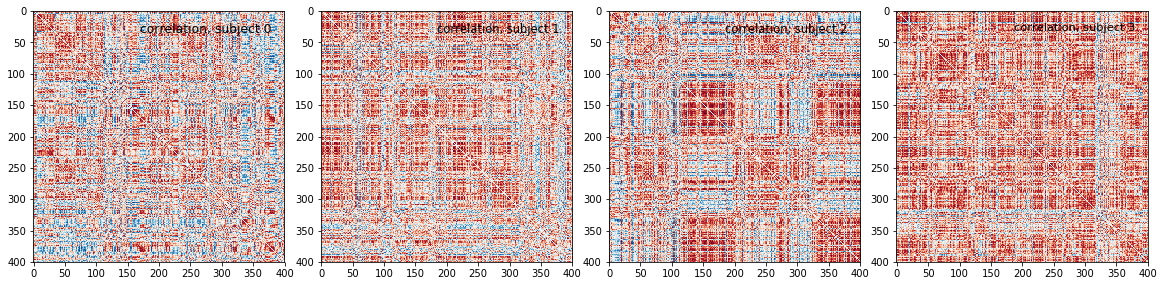

In [43]:
plot_matrices(correlation_matrices_oa[:4], 'correlation')

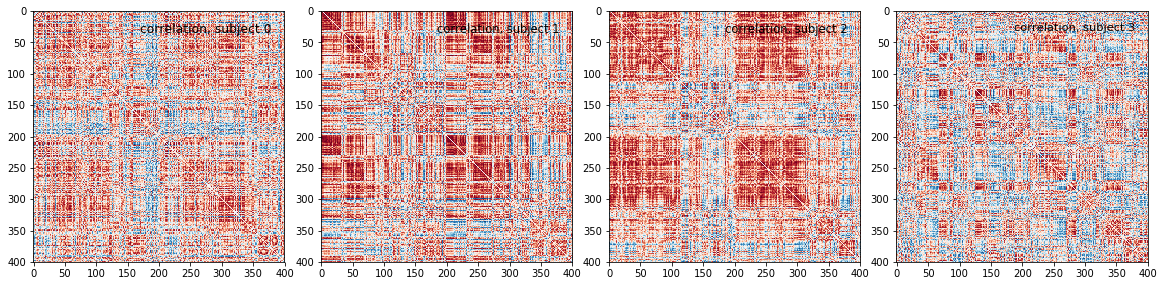

In [44]:
plot_matrices(correlation_matrices_ya[:4], 'correlation')

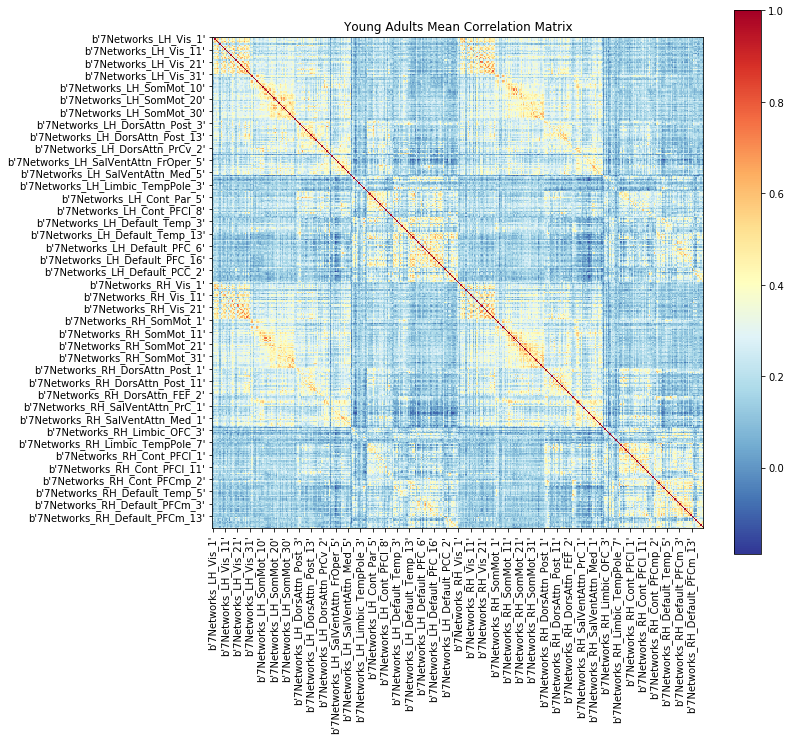

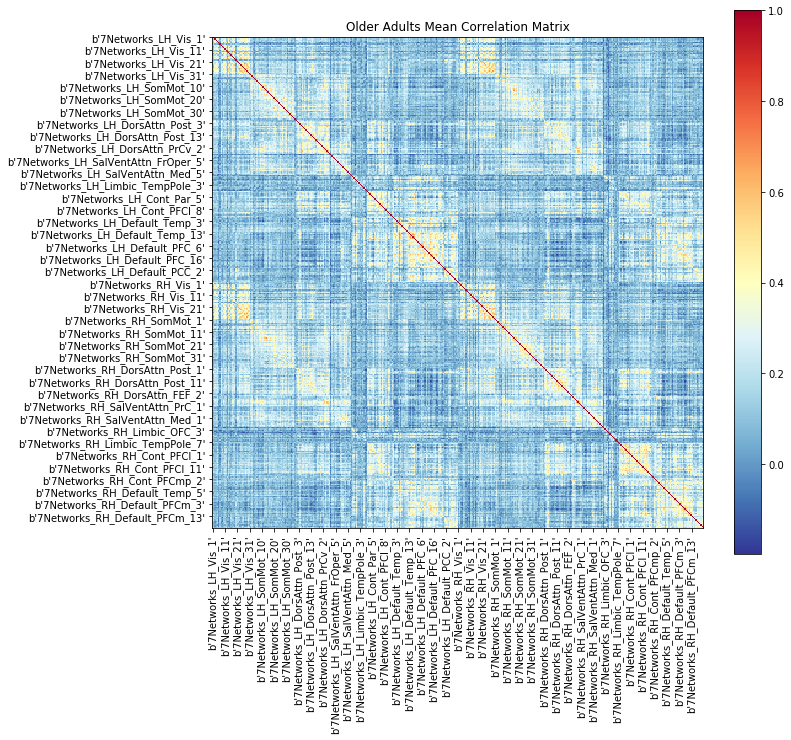

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

fig1 = plt.figure(figsize=(11,10))
plt.imshow(mean_correlation_matrix_ya, interpolation='None', cmap='RdYlBu_r')
plt.yticks(range(0, len(labels), 10), labels[::10]);
plt.xticks(range(0, len(labels), 10), labels[::10], rotation=90);
plt.title('Young Adults Mean Correlation Matrix')
plt.colorbar();

fig2 = plt.figure(figsize=(11,10))
plt.imshow(mean_correlation_matrix_oa, interpolation='None', cmap='RdYlBu_r')
plt.yticks(range(0, len(labels), 10), labels[::10]);
plt.xticks(range(0, len(labels), 10), labels[::10], rotation=90);
plt.title('Older Adults Mean Correlation Matrix')
plt.colorbar();

### Visualize group mean correlation matrices on glass brain

In [ ]:
# from nilearn import plotting

# plotting.plot_connectome(mean_correlation_matrix_oa, schaefer_coords, \
#                          title='mean correlation over {0} OA subjects'.format(len(correlation_matrices_oa)), \
#                          edge_threshold='90%')


### Use the Network-Based Statistic to analyze group functional connectivity differences

Read more about NBS in [Zalesky (2010)](10.1016/j.neuroimage.2010.06.041).

This uses the [Brain Connectivity Toolbox for Python](https://github.com/aestrivex/bctpy).

    x : NxNxP np.ndarray
        matrix representing the first population with P subjects. must be
        symmetric.
    y : NxNxQ np.ndarray
        matrix representing the second population with Q subjects. Q need not
        equal P. must be symmetric.
    thresh : float
        minimum t-value used as threshold
    k : int
        number of permutations used to estimate the empirical null 
        distribution
    tail : {'left', 'right', 'both'}
        enables specification of particular alternative hypothesis
        'left' : mean population of X < mean population of Y
        'right' : mean population of Y < mean population of X
        'both' : means are unequal (default)

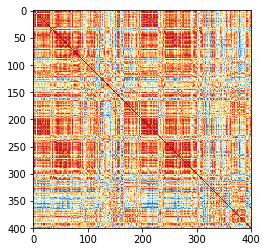

In [46]:
plt.imshow(correlation_matrices_ya[1,:,:], interpolation='None', cmap='RdYlBu_r')

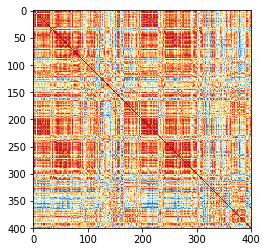

In [48]:
X = correlation_matrices_ya.transpose()
Y = correlation_matrices_oa.transpose()
plt.imshow(X[:,:,1], interpolation='None', cmap='RdYlBu_r')

import scipy.io
scipy.io.savemat('data/%s_OA_wb_cor.mat' % task, mdict = {'OA_wb_cormat': Y})
scipy.io.savemat('data/%s_YA_wb_cor.mat'% task, mdict = {'YA_wb_cormat': X})

In [ ]:
from bct import nbs

pval, adjwb1, null = nbs.nbs_bct(X, Y, thresh=3.5, k=5000, tail='right', paired=False, verbose=False)
save('data/%s_whole_brain_YA_1_OA_-1_nbs' % task, adjwb1)

In [ ]:
print(pval)

In [ ]:
from nilearn import plotting
plotting.plot_connectome(adjwb1, schaefer_coords, title='NBS contrast YA > OA', node_size=0)

In [ ]:
pval, adjwb2, null = nbs.nbs_bct(X, Y, thresh=3.5, k=5000, tail='left', paired=False, verbose=False)
save('data/%s_whole_brain_YA_-1_OA_1_nbs.edge' % task, adjwb2)
print(pval)

In [ ]:
plotting.plot_connectome(adjwb2, schaefer_coords, title='NBS contrast OA > YA', node_size=0)

### Create DMN mask

In [51]:
labels_df = pd.DataFrame(labels, columns = ['labels'], dtype=str)
dmn_mask = labels_df.index[labels_df['labels'].str.contains('Default')]
fpn_mask = labels_df.index[labels_df['labels'].str.contains('Cont')]

Young Adults DMN
(400, 400, 48)
(91, 91, 48)
Older Adults DMN
(400, 400, 44)
(91, 91, 44)


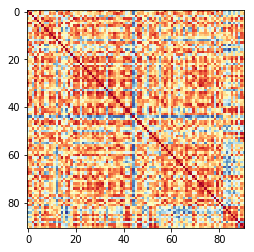

In [52]:
print('Young Adults DMN')
print(X.shape)
X_dmn = []
X_dmn = X[dmn_mask,:,:]
X_dmn = X_dmn[:,dmn_mask,:]
print(X_dmn.shape)

print('Older Adults DMN')
print(Y.shape)
Y_dmn = []
Y_dmn = Y[dmn_mask,:,:]
Y_dmn = Y_dmn[:,dmn_mask,:]
print(Y_dmn.shape)

plt.imshow(X_dmn[:,:,1], interpolation='None', cmap='RdYlBu_r')
scipy.io.savemat('data/%s_OA_dmn_cor.mat' % task, mdict = {'OA_dmn_cormat': Y_dmn})
scipy.io.savemat('data/%s_YA_dmn_cor.mat'% task, mdict = {'YA_dmn_cormat': X_dmn})

Young Adults Control
(400, 400, 48)
(52, 52, 48)
Older Adults Control
(400, 400, 44)
(52, 52, 44)


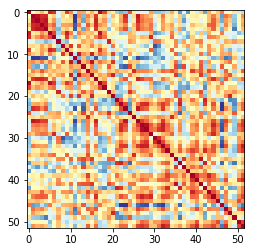

In [53]:
print('Young Adults Control')
print(X.shape)
X_fpn = []
X_fpn = X[fpn_mask,:,:]
X_fpn = X_fpn[:,fpn_mask,:]
print(X_fpn.shape)

print('Older Adults Control')
print(Y.shape)
Y_fpn = []
Y_fpn = Y[fpn_mask,:,:]
Y_fpn = Y_fpn[:,fpn_mask,:]
print(Y_fpn.shape)

plt.imshow(X_fpn[:,:,1], interpolation='None', cmap='RdYlBu_r')

scipy.io.savemat('data/%s_OA_fpn_cor.mat' % task, mdict = {'OA_fpn_cormat': Y_fpn})
scipy.io.savemat('data/%s_YA_fpn_cor.mat' % task, mdict = {'YA_fpn_cormat': X_fpn})

In [ ]:
from bct import nbs

pval, adjd1, null = nbs.nbs_bct(X_dmn, Y_dmn, thresh=3.0, k=5000, tail='right', paired=False, verbose=False)
np.save('data/%s_nbs_dmn_ya_1_oa_-1' % task, adjd1)

max component size is 24
estimating null distribution with 5000 permutations
permutation 0 of 5000.  p-value so far is 0.000
permutation 500 of 5000.  p-value so far is 0.048
permutation 1000 of 5000.  p-value so far is 0.042
permutation 1500 of 5000.  p-value so far is 0.044


In [ ]:
print(pval)

In [ ]:
plotting.plot_connectome(adjd1, np.asarray(schaefer_coords)[dmn_mask], title='NBS contrast DMN YA > OA')

In [ ]:
pval, adjf1, null = nbs.nbs_bct(X_fpn, Y_fpn, thresh=3.0, k=5000, tail='right', paired=False, verbose=False)
np.save('data/%s_nbs_fpn_ya_1_oa_-1' % task, adjf1)

In [ ]:
print(pval)

In [ ]:
plotting.plot_connectome(adjf1, np.asarray(schaefer_coords)[fpn_mask], title='NBS contrast FPN YA > OA')

### BCT graph metrics by age group

In [ ]:
thresh_range = [0.10, 0.15, 0.20, 0.25]

In [ ]:
import bct
from bct import algorithms
import pandas as pd

ci = pd.read_csv('schaefer_affiliation.csv', sep = ',')
for thresh in thresh_range:
    bct_data_oa = [] #just in case
    bct_data_oa = pd.DataFrame(columns = ('efficiency_global', 'clustering_coef', 'modularity', \
                                         'efficiency_global_dmn', 'clustering_coef_dmn', 'modularity_dmn', 'efficiency_local_dmn','partic_coef_dmn', \
                                          'efficiency_global_fpn', 'clustering_coef_fpn', 'modularity_fpn', 'efficiency_local_fpn','partic_coef_fpn'))
    for sub in range(0,np.ma.size(Y, 2)):
        thresh_mat = bct.threshold_proportional(Y[:,:,sub], thresh)      
        ge = algorithms.efficiency_wei(thresh_mat, local = False)
        le_node = algorithms.efficiency_wei(thresh_mat, local = True)
        le = le_node.mean()
        cc = algorithms.clustering_coef_wu(thresh_mat).mean()
        Ci, Q = algorithms.modularity_und(thresh_mat)
        partic_node = algorithms.participation_coef(Y,ci)
        partic = partic_node.mean()
        
        thresh_dmn = bct.threshold_proportional(Y_dmn[:,:,sub], thresh) 
        
        #what to do about inf values here?
        ge_dmn = algorithms.efficiency_wei(thresh_dmn, local = False)
        cc_dmn = algorithms.clustering_coef_wu(thresh_dmn).mean()
        Ci_dmn, Q_dmn = algorithms.modularity_und(thresh_dmn)
        partic_dmn = partic_node[dmn_mask].mean()
        le_dmn = le_node[dmn_mask].mean()
        
        thresh_fpn = bct.threshold_proportional(Y_fpn[:,:,sub], thresh) 
        
        ge_fpn = algorithms.efficiency_wei(thresh_fpn, local = False)
        cc_fpn = algorithms.clustering_coef_wu(thresh_fpn).mean()
        Ci_fpn, Q_dmn = algorithms.modularity_und(thresh_fpn)
        partic_fpn = partic_node[fpn_mask].mean()
        le_fpn = le_node[fpn_mask].mean()
    
        bct_data_oa = bct_data_oa.append(pd.DataFrame({'efficiency_global': ge, 'clustering_coef': cc, 'modularity': Q, 'efficiency_local_mean': le, 'partic_coef_mean': partic, \
                                                       'efficiency_global_dmn': ge_dmn, 'clustering_coef_dmn': cc_dmn, 'modularity_dmn': Q_dmn, 'efficiency_local_dmn': le_dmn, 'partic_coef_dmn': partic_dmn, \
                                                       'efficiency_global_fpn': ge_fpn, 'clustering_coef_fpn': cc_fpn, 'modularity_fpn': Q_fpn, 'efficiency_local_fpn': le_fpn, 'partic_coef_fpn': partic_fpn}, index=[0]), ignore_index=True)
    np.save('data/%s_bct_oa_thr_%s' % (task, str(thresh).split('.')[1]), bct_data_oa)
        
print(bct_data_oa[:5])


In [ ]:
import bct
from bct import algorithms
import pandas as pd

for thresh in thresh_range:
    bct_data_ya = [] #just in case
    bct_data_ya = pd.DataFrame(columns = ('efficiency_global', 'clustering_coef', 'modularity', 'efficiency_global_dmn', 'clustering_coef_dmn', 'modularity_dmn'))
    for sub in range(0,np.ma.size(X, 2)):
        thresh_mat = bct.threshold_proportional(X[:,:,sub], thresh)      
        ge = algorithms.efficiency_wei(thresh_mat, local = False)
        cc = algorithms.clustering_coef_wu(thresh_mat).mean()
        Ci, Q = algorithms.modularity_und(thresh_mat)
        
        thresh_dmn = bct.threshold_proportional(X_dmn[:,:,sub], thresh) 
        
        ge_dmn = algorithms.efficiency_wei(thresh_dmn, local = False)
        cc_dmn = algorithms.clustering_coef_wu(thresh_dmn).mean()
        Ci_dmn, Q_dmn = algorithms.modularity_und(thresh_dmn)
        
        bct_data_ya = bct_data_ya.append(pd.DataFrame({'efficiency_global': ge, 'clustering_coef': cc, 'modularity': Q, 'efficiency_global_dmn': ge_dmn, 'clustering_coef_dmn': cc_dmn, 'modularity_dmn': Q_dmn}, index=[0]), ignore_index=True)
    np.save('data/%s_bct_ya_thr_%s' % (task, str(thresh).split('.')[1]), bct_data_ya)
        
print(bct_data_ya[:5])


In [ ]:
from scipy import stats

t, p = stats.ttest_ind(bct_data_ya, bct_data_oa, equal_var=False)
print('global efficiency, clustering, modularity \n t-statistics: %s \n p-values: %s' %(t, p))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.violinplot(bct_data_ya['efficiency_global'])
plt.violinplot(bct_data_oa['efficiency_global'])

In [ ]:
plt.violinplot(bct_data_ya['clustering_coef'])
plt.violinplot(bct_data_oa['clustering_coef'])

In [ ]:
plt.violinplot(bct_data_ya['modularity'])
plt.violinplot(bct_data_oa['modularity'])